In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import PIL
def load_image(path):
  im_frame = PIL.Image.open(path)
  im_frame=im_frame.resize((30,30))
  np_frame = np.float32(im_frame)
  print(np_frame)
  return np_frame
target=load_image("/content/6.png")

[[  0.   0.   0.   0.   0.   0.   7.   2.   2.   7.   7.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   3.   2.   3.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   3.   2.   3.   7.   7.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   7.   3.   2.   2.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   7.   7.   2.   3.   7.   7.   0.   0.   0.
    0.   0.   0.   3.  16.  21.   0.   0.   0.   3.   2.   3.   7.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   7.   7.   2.   2.   7.   3.   0.   0.   0.
    0.   0. 237.  15.   4.  25.   0.   0.   0.   3.   2.   3.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   7.   7.   2.   3.   7.   3.   0.   0.   0.
    7.  20.   4. 241.  27.   7.   0.   0.   0.   3.   2.   2.   7.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   7.   2.   3.   7.   7.   0.   0.   3.
   25.   4.   4.  13.  10.   0.   0.   0.   0.   3.   2.   2.   7.   0.
    0.   0.]
 [  7.   0.   7.   7.   7.   7.   3.   2.   3.   7.   3.  

In [2]:
def make_graph(np_image):
  size=np_image.shape
  #A=np.zeros((size[0]*size[0], size[0]*size[0]))
  A=np.zeros((900,900))
  for i in range(900):
      A[i][i]=1
      A[(i+1)%size[0]][i]=1
      A[(i+1)%size[0]][(i+1)%size[0]]=1
      A[(i+1)%size[0]][(i-1)%size[0]]=1
      A[(i-1)%size[0]][i]=1
      A[(i-1)%size[0]][(i+1)%size[0]]=1
      A[(i-1)%size[0]][(i-1)%size[0]]=1
      A[i][(i+1)%size[0]]=1
      A[i][(i-1)%size[0]]=1

  return A

A_hat=make_graph(target)

In [ ]:
class GNN_Single_Layer(nn.Module):
  def __init__(self, c_in, c_out):
    super(GNN_Single_Layer, self).__init__()
    self.linear= nn.Linear(c_in, c_out,bias=False)   # y=x.WT+b 
    self.non_lin=nn.ReLU(inplace=True)
  def forward(self, H, A_hat, W):
    #print("H:",H[0][0],"W:",W[0][0])
    H_mod=self.linear(H.T)                          #H=(900x1) H.T=(1x900) H.T@W=(1x900)x()   torch.matmul(H.T,W.T)      
    #print("H@W:",H_mod[0][0])
    H_mod=torch.bmm(H_mod[None,:], A_hat.T[None,:])
    #print("A@H@W:",H_mod[0][0][0])
    H_mod=H_mod.T/9
    #print("inv(D)@A@W:", H_mod[0][0][0])
    Z=self.non_lin(H_mod)
    Z=nn.functional.normalize(Z,p=2,dim=0)
    #print("Relu(AHW):",Z[0][0])
    return torch.squeeze(Z,-1)

class GCN_multi_layer(nn.Module):
  def __init__(self, c_in,c_out,num_layer):
    super(GCN_multi_layer, self).__init__()
    layers=[]
    for i in range(num_layer):
      layers+=[GNN_Single_Layer(c_in,c_out)]
    self.layers=nn.ModuleList(layers)
  def forward(self,X, A_hat, W, num_layers):
    for i in range (num_layers):
      X=self.layers[i](X, A_hat,W)
    return X

def train(X, Y, A, W, time, loss_fn, optimizer, epochs):
  loss=0
  for i in range(epochs):
    optimizer.zero_grad()
    output=model(X,A,W,time)
    output=torch.squeeze(output, -1)
    loss=loss_fn(output.squeeze(),Y)
    loss_list.append(loss)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      for param in model.parameters():
        param -= learning_rate * param.grad
    #print(output[:5])
  return loss,output

X=torch.rand(900, 1).float()
A=torch.from_numpy(A_hat).float()
Y=nn.functional.normalize(torch.flatten(torch.from_numpy(target).float()), p=2, dim=0)
model=GCN_multi_layer(900,900,100)
W=torch.rand(900,900, requires_grad=True).float()
time=100
learning_rate=0.1
loss_fn=nn.MSELoss()
loss_list = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs=2000
model.train()
loss,output=train(X, Y, A, W, time, loss_fn, optimizer, epochs)

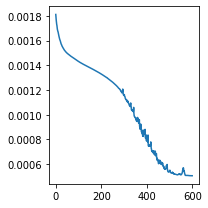

In [21]:
step = np.linspace(0,epochs,epochs)
plt.plot(step,torch.FloatTensor(loss_list).detach().numpy())

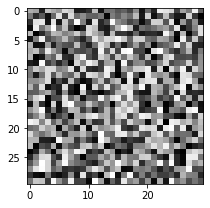

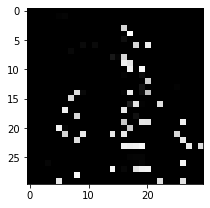

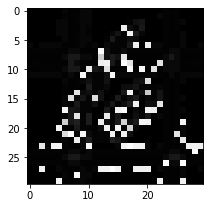

In [22]:
from matplotlib import pyplot as plt
import numpy as np

# Set the figure size
plt.rcParams["figure.figsize"] = [3.00, 3.00]
plt.rcParams["figure.autolayout"] = True

# Random data points
initial=X.reshape(([30,30])).detach().numpy()
final=output.reshape(([30,30]))
final=final.detach().numpy()
# Plot the data using imshow with gray colormap
final2=Y.reshape(([30,30]))
final2=final2.detach().numpy()
plot0 = plt.figure(1)
plt.imshow(initial, cmap='gray')
plot1 = plt.figure(2)
plt.imshow(final, cmap='gray')
plot2 = plt.figure(3)
plt.imshow(final2, cmap='gray')

# Display the plot
plt.show()

In [10]:
from PIL import Image as im
final=Y.reshape(([30,30]))
img2=im.fromarray(final.detach().numpy())
img2=img2.convert('RGB')
img2.save('/content/Y.png')